In [57]:
import pandas as pd
import numpy as np
import os
from sklearn.tree import DecisionTreeClassifier 
from dataclasses import dataclass
from typing import List, Optional, Union, Tuple, Dict
from sklearn.metrics import classification_report, confusion_matrix
import graphviz
from sklearn import tree

In [89]:
def is_athlete(h, w):
    if h >= 190: return 'yes'
    if h > 170 and w < 90: return 'yes'
    return 'no'
# Height > 170 and Weight < 90 or Height >= 190
size = 20

heights = np.random.randint(160, 200, size=size)
weights = np.random.randint(70, 95, size=size)
 
df = pd.DataFrame({'height': heights, 'weight': weights})
df['athlete'] = df.apply(lambda x: is_athlete(x['height'], x['weight']), axis=1)
df['athlete'].value_counts()

yes    11
no      9
Name: athlete, dtype: int64

In [90]:
@dataclass
class Rule:
    predictor: str
    comparator: str 
    # assert comparator in ['lt', 'eq', 'gt', 'leq', 'geq']
    value: Union[int, str]
    mapper = {'lt': '<', 'eq': '=', 'gt': '>', 'leq': '<=', 'geq': '>='}
    
    def stringify(self):
        assert self.comparator in ['lt', 'eq', 'gt', 'leq', 'geq']
        if type(self.value) == str: assert self.comparator == 'eq'
        
        rule = f'{self.predictor} {self.mapper[self.comparator]} {self.value}'
        return rule
    
    def apply(self, X: Union[pd.DataFrame, pd.Series]):
        comparator = self.mapper[self.comparator]
        if comparator == ">=":
            mask = X[self.predictor] >= self.value
        else:
            mask = X[self.predictor] == self.value
        
        return mask

In [91]:
class TreeNode:
    def __init__(self, rule:Rule=None):
        self.left = None
        self.right = None
        self.measure = None # Gini value (or other metric) before applying
        # the rule of the node
        self.split_measure = None # Weighted sum of children Gini
        self.rule = rule
        self.predictor : pd.Series = None # the predictor values
        self.target : pd.Series = None
        self.leaf = None
        self.action = None
        self.values = None
        self.index = None
        
    def set(self, left=None, right=None, measure=None, split_measure=None, 
            rule=None, predictor=None, target=None, index=None):
        if left is not None:
            self.left = left
        if right is not None:
            self.right = right
        if measure is not None:
            self.measure = measure
        if split_measure is not None:
            self.split_measure = split_measure
        if rule is not None:
            self.rule = rule
        if predictor is not None:
            self.predictor = predictor
        if target is not None:
            self.target = target
        if index is not None:
            self.index = index
        
    def is_leaf(self):
        if self.left is None and self.right is None:
            self.leaf = True
        else:
            self.leaf = False
        
    def get_depth_from_index(self):
        assert self.index is not None
        depth = int(np.floor(np.log2(self.index+1)))
        self.depth = depth
        return depth
        
    def act(self):
        assert self.target is not None
        self.values = self.target.value_counts()
        self.action = self.values.index[0]
        self.is_leaf()
        self.get_depth_from_index()
        
    def stringify(self, total_len=None) -> str:
        s = ""
        max_len = 0
        
        if self.index is not None:
            cur = f'Index: {self.index}'
            max_len = max(max_len, len(cur))
            s += cur + "\n"
        
        if self.rule is not None:
            cur = self.rule.stringify()
            max_len = max(max_len, len(cur))
            s += cur + "\n"
            
        if self.measure is not None:
            cur = f'Gini: {self.measure}'
            max_len = max(max_len, len(cur))
            s += cur + "\n"
            
        if self.values is not None:
            cur = f'Samples: {self.values.sum()}'
            max_len = max(max_len, len(cur))
            s += cur + "\n"
            
            cur = f'Values: {self.values.to_dict()}'
            max_len = max(max_len, len(cur))
            s += cur + "\n"
            
            cur = f'Class: {self.action}'
            max_len = max(max_len, len(cur))
            s += cur + "\n"
            
        # if total_len is not None:
        #     if len(s) < total_len:
        #         diff = total_len - len(s)
        #         s = " "*diff//2 + s + " "*(diff-diff//2)
        
        return s

In [92]:
class TreeVisualizer:
    def __init__(self, fname='dt.txt') -> None:
        self.time = 0
        self.fname = fname
        
    def traverse_tree(self, node: TreeNode, curr_array: List, char_len:int=25, space_len:int=10):
        if node is None:
            self.time += 1
            return
        
        if not node.leaf:
            self.traverse_tree(node.left, curr_array=curr_array, 
                        char_len=char_len, space_len=space_len)
        
        idx = node.index
        num_spaces = (char_len+space_len)*self.time
        node_str = node.stringify(total_len=char_len)
        curr_str = "\n".join([" "*num_spaces + el for el in node_str.split("\n")])
        curr_array[idx] = curr_str
        
        self.time += 1
        
        if not node.leaf:
            self.traverse_tree(node.right, curr_array, char_len=char_len, 
                        space_len=space_len)
        
    def visualize(self, tree: TreeNode, tree_depth:int, char_len:int=25, space_len:int=10):
        curr_array = ['' for i in range(2**(tree_depth+1)-1)]
        self.traverse_tree(tree, curr_array=curr_array, char_len=char_len,
                           space_len=space_len)
        
        
        for curr_depth in range(tree_depth+1):
            idxs = [i for i in range(2**curr_depth-1, 2**(curr_depth+1)-1)]
            elements = [curr_array[idx].split("\n") for idx in idxs]
            
            max_lines = max([len(i) for i in elements])
            # print(elements, max_lines)
            for i in range(max_lines):
                curr_len = 0
                
                for j in range(len(elements)):
                    if i >= len(elements[j]): continue
                    el = elements[j][i]
                    # print(el, j, i)
                    curr_spaces = [i for i in range(len(el)) if el[i]!=' ']
                    if len(curr_spaces) == 0: 
                        continue
                    curr_spaces = curr_spaces[0]
                    diff = curr_spaces - curr_len
                    curr_el = diff*" "+el.lstrip(" ")
                    curr_len += len(curr_el)
                    print(curr_el.rstrip("\n"), end='', sep='')

                print()
            
        # for idx, el in enumerate(curr_array):
        #     depth = int(np.floor(np.log2(idx+1)))
            
        #     if depth > curr_depth:
        #         # print(idx, depth)
        #         curr_depth += 1
        #         prev_lines = len(curr_array[idx-1].split("\n")) + 2
        #         curr_lines += prev_lines
                
        #     string = el

In [93]:
class DecisionTree:
    def __init__(self, max_depth=np.inf):
        self.tree : TreeNode = None
        self.max_depth = max_depth
        self.metric = 'gini'
        self.tree_depth = 0
        self.visualizer = TreeVisualizer()
        
    def __get_dtype(self, x:pd.Series) -> str:
        dtype = 'numeric'
        if x.dtype == 'O': dtype = 'categorical'
        return dtype
        
    def __get_gini_impurity(self, y: pd.Series):
        vc = y.value_counts(normalize=True)
        return 1-(vc*vc).sum()
        
    def __get_impurity(self, y: pd.Series):
        if self.metric == 'gini':
            return self.__get_gini_impurity(y)
        else:
            raise NotImplementedError
        
    def __get_thresholds(self, x:pd.Series, dtype:str='numeric'):
        # thresholds are >= for numeric and == for string
        if dtype == 'numeric':
            return sorted(x.unique())[1:]
        else:
            return x.unique()
        
    def __get_score(self, predictor: pd.Series, target: pd.Series, dtype:str='numeric') \
                -> Union[int, Union[int, str]]:
        impurity = 1.0
        chosen_thresh = None
        
        thresholds = self.__get_thresholds(predictor, dtype=dtype)
        for threshold in thresholds:
            if dtype == 'numeric':
                mask = predictor >= threshold
            else:
                mask = predictor == threshold
            
            left_weight = mask.sum()/len(mask)
            right_weight = 1 - left_weight    
            left_impurity = self.__get_impurity(target[mask])
            right_impurity = self.__get_impurity(target[~mask])
            
            curr_impurity = left_weight*left_impurity + right_weight*right_impurity
            
            if curr_impurity < impurity:
                impurity = curr_impurity
                chosen_thresh = threshold
                
        return impurity, chosen_thresh
    
    def __build_tree(self, X:pd.DataFrame, y: pd.Series, cur_depth:int=0, index:int=0) -> TreeNode:
        if cur_depth > self.max_depth:
            return None
        
        imp_before_split = self.__get_impurity(y)
        
        if imp_before_split == 0:
            curr_node = TreeNode()
            curr_node.set(measure=imp_before_split, target=y, index=index)
            curr_node.act()
            self.tree_depth = max(self.tree_depth, curr_node.depth)
            return curr_node
        
        best_col = None
        chosen_thresh = None
        best_impurity = 1.0
        chosen_dtype = None
        
        for col in X.columns:
            dtype = self.__get_dtype(X[col])
            impurity, thresh = self.__get_score(X[col], y)
            
            if impurity < best_impurity:
                best_impurity = impurity
                best_col = col
                chosen_thresh = thresh
                chosen_dtype = dtype
        
        comparator = 'eq' if chosen_dtype == 'categorical' else 'geq'
        rule = Rule(predictor=best_col, comparator=comparator, value=chosen_thresh)
        
        curr_node = TreeNode(rule=rule)
        curr_node.set(measure=imp_before_split, split_measure=best_impurity, 
                      predictor=best_col, target=y, index=index)
        

        mask = rule.apply(X)
        left_X, left_y, right_X, right_y = X[mask], y[mask], X[~mask], y[~mask]
        left_child = self.__build_tree(left_X, left_y, cur_depth=cur_depth+1, index=2*index+1)
        right_child = self.__build_tree(right_X, right_y, cur_depth=cur_depth+1, index=2*index+2)
                        
        curr_node.left = left_child
        curr_node.right = right_child
        
        curr_node.act()
        self.tree_depth = max(self.tree_depth, curr_node.depth)
        
        return curr_node
      
    def train(self, X:pd.DataFrame, y:pd.Series):
        self.tree = self.__build_tree(X, y, 0)
        print('[INFO] Trained Tree!')
    
    def prune_leaves(self, node: TreeNode, impurity_thresh=0.2):
        # action is changed to None for pruned leaves
        
        if node is None:
            return
        
        if node.left is not None:
            if node.left.leaf:
                if node.left.measure >= impurity_thresh: 
                    node.left.action = None
                    print(f'[INFO] Pruned leaf with index: {node.left.index} as \
                          impurity={node.left.measure}')
            else:
                node.left = self.prune_leaves(node.left, impurity_thresh=impurity_thresh)
                
        if node.right is not None:
            if node.right.leaf:
                if node.right.measure >= impurity_thresh: 
                    node.right.action = None
                    print(f'[INFO] Prune leaf with index: {node.right.index} as \
                          impurity={node.right.measure}')
            else:
                node.right = self.prune_leaves(node.right, impurity_thresh=impurity_thresh)
                
        return node
               
    def prune(self, impurity_thresh=0.3):
        if impurity_thresh is None:
            pass
        else:
            self.tree = self.prune_leaves(self.tree)
            print('[INFO] Pruning complete!')
        

    def predict_single(self, X:pd.Series, node:TreeNode):
        if node is None:
            raise Exception
        
        if node.leaf:
            return node.action
        
        rule = node.rule
        left = rule.apply(X=X)
        
        if left:
            return self.predict_single(X, node.left)
        else:
            return self.predict_single(X, node.right)
        
    def predict(self, X: pd.DataFrame):
        n = len(X)
        outputs = []
        
        for i in range(n):
            sample = X.iloc[i, :]
            output = self.predict_single(sample, self.tree)
            outputs.append(output)
            
        return pd.Series(outputs)

    def visualize(self, char_len:int=25, space_len:int=10):
        self.visualizer.visualize(self.tree, tree_depth=self.tree_depth, char_len=char_len,
                                  space_len=space_len)
        
    def score(self, X, y):
        outputs = self.predict(X)
        print(classification_report(y, outputs))
        

In [94]:
X_train = df.loc[:, ['height', 'weight']]
y_train = df.loc[:, 'athlete']

dt = DecisionTree()
dt.train(X_train, y_train)

[INFO] Trained Tree!


In [95]:
dt.visualize(char_len=35, space_len=2)

                                                                                                                                                                                         Index: 0
                                                                                                                                                                                         height >= 172
                                                                                                                                                                                         Gini: 0.4949999999999999
                                                                                                                                                                                         Samples: 20
                                                                                                                                                                                         Values: {'yes':

In [88]:
dt.prune()

[INFO] Pruning complete!


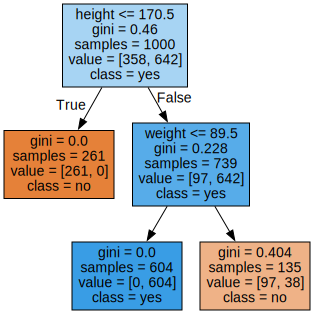

In [24]:
# X_train = df.loc[:, ['height', 'weight']].values
# y_train = df.loc[:, 'athlete'].apply(lambda x: 1 if x=='yes' else 0).values

# clf = DecisionTreeClassifier(max_depth=2)
# model = clf.fit(X_train, y_train)

# # DOT data
# dot_data = tree.export_graphviz(clf, out_file=None,
#                                 feature_names=['height', 'weight'],
#                                 class_names=['no', 'yes'],
#                                 filled=True)
# # Draw graph
# graph = graphviz.Source(dot_data, format="png")
# graph